In [72]:
import os
import glob
from collections import defaultdict, Counter
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from pymutspec.annotation import CodonAnnotation, mutations_summary

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.spatial.distance import cityblock
from sklearn.metrics import mean_squared_error
from Bio import SeqIO

import warnings
warnings.filterwarnings("ignore")

from utils import (
    prepare_exp_aa_subst, prepare_aa_subst, get_equilibrium_freqs, 
    calc_metrics, amino_acid_codes
)

## Load input data

In [25]:
coda = CodonAnnotation(2)

# load spectra
spectra = pd.read_csv(
    '../192/1data_derivation/dataset/MutSpecVertebrates12.csv.gz', index_col=[0,2])

# load mutations
mut_df = pd.read_csv('./vertebrates_aa_subst/dataset/obs_muts.csv')\
    .rename(columns={'RefAa': 'aa1', 'AltAa': 'aa2', 'ProbaMut': 'count'})

In [23]:
spectra.head()

Class  Mut   Observed    Expected   MutSpec
Gene Species                                                        
CO1  Crocuta_crocuta  Mammalia  A>C        NaN  115.066667  0.000000
     Crocuta_crocuta  Mammalia  A>G  11.500444  173.333333  0.162818
     Crocuta_crocuta  Mammalia  A>T        NaN  115.066667  0.000000
     Crocuta_crocuta  Mammalia  C>A        NaN   71.466667  0.000000
     Crocuta_crocuta  Mammalia  C>G        NaN   71.466667  0.000000

In [26]:
mut_df.head()

,Mut,MutType,Site,PosInCodon,RefCodon,AltCodon,aa1,aa2,ProbaRef,count,RefNode,AltNode,species,gene,class,edge_nobs,species_nobs
0,A[A>G]T,0,112,1,ATT,GTT,I,V,0.958489,0.849141,Node5,Node6,Macaca_mulatta,ND6,Mammalia,1.70197,60.8728
1,T[G>A]T,0,127,1,GTT,ATT,V,I,0.974793,0.970650,Node6,Node12,Macaca_mulatta,ND6,Mammalia,4.31735,60.8728
2,G[A>G]T,0,301,1,ATA,GTA,M,V,0.999990,0.999990,Node24,RN_6,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
3,T[G>A]T,0,109,1,GTA,ATA,V,M,0.999990,0.999990,Node22,RN_32,Macaca_mulatta,ND6,Mammalia,0.99999,60.8728
4,A[A>G]T,0,97,1,ATT,GTT,I,V,1.000000,1.000000,Node25,RN_5,Macaca_mulatta,ND6,Mammalia,1.00000,60.8728


In [35]:
# load genes amino acid content

aa_content = []
for fasta_file in glob.glob('../192/1data_derivation/nemu_input/*.fasta'):
    file = SeqIO.parse(fasta_file, "fasta")
    gene = os.path.basename(fasta_file).replace('.fasta', '')
    for rec in file:
        seq = str(rec.seq)
        species = rec.description.split(';')[-1]
        species = '_'.join(species.split('_')[:-1])
        cur_aa_counts = dict(Counter(seq))
        cur_aa_counts['gene'] = gene
        cur_aa_counts['species'] = species
        aa_content.append(cur_aa_counts)
aa_content_df = pd.DataFrame(aa_content)\
    .set_index(['gene', 'species'])\
        .drop(['X', 'J', 'B', 'Z'], axis=1).fillna(0)\
            .rename(columns=amino_acid_codes)
aa_content_df

Met   Val   Ser   Phe  Asp   Gln   Ala   Pro  \
gene species                                                                 
A6   Abramis_brama           10.0  19.0   7.0  13.0  1.0   8.0  21.0  18.0   
     Acanthurus_nigricans     8.0  10.0  11.0  13.0  1.0   9.0  17.0  17.0   
     Acanthurus_triostegus    8.0  10.0   9.0  12.0  1.0   9.0  18.0  17.0   
     Adelomyia_melanogenys    8.0   7.0  17.0  10.0  2.0   8.0  17.0  16.0   
     Aepyornis_maximus       11.0   5.0  15.0  11.0  1.0  10.0  17.0  17.0   
...                           ...   ...   ...   ...  ...   ...   ...   ...   
ND6  Vidua_purpurascens       7.0  30.0  11.0  10.0  4.0   0.0  12.0   4.0   
     Vireo_olivaceus          8.0  36.0  18.0  12.0  3.0   0.0  12.0   4.0   
     Vireo_solitarius         9.0  35.0  18.0  13.0  2.0   0.0  14.0   4.0   
     Ziphius_cavirostris      9.0  28.0  12.0  14.0  3.0   1.0   6.0   3.0   
     Zonotrichia_albicollis   6.0  35.0  13.0   8.0  2.0   0.0  11.0   4.0   

                             Leu   Gly   Ile  Trp   Thr  Arg   Asn  His  Lys  \
gene species                                                                   
A6   Abramis_brama            47  10.0  22.0  5.0  19.0  6.0  10.0  3.0  1.0   
     Acanthurus_nigricans     55  10.0  21.0  5.0  22.0  6.0   9.0  3.0  1.0   
     Acanthurus_triostegus    56  11.0  21.0  5.0  22.0  6.0   9.0  3.0  1.0   
     Adelomyia_melanogenys    56   8.0  22.0  4.0  21.0  5.0   9.0  4.0  4.0   
     Aepyornis_maximus        60   7.0  20.0  4.0  21.0  5.0  10.0  3.0  3.0   
...                          ...   ...   ...  ...   ...  ...   ...  ...  ...   
ND6  Vidua_purpurascens       27  28.0   2.0  4.0   5.0  1.0   2.0  1.0  0.0   
     Vireo_olivaceus          21  27.0   6.0  4.0   2.0  6.0   3.0  0.0  0.0   
     Vireo_solitarius         21  24.0   5.0  4.0   2.0  6.0   4.0  0.0  0.0   
     Ziphius_cavirostris      19  27.0  14.0  4.0   7.0  1.0   4.0  0.0  3.0   
     Zonotrichia_albicollis   32  31.0   2.0  4.0   2.0  4.0   3.0  0.0  0.0   

                             Tyr  Glu  Cys  
gene species                                
A6   Abramis_brama           3.0  4.0  0.0  
     Acanthurus_nigricans    5.0  4.0  0.0  
     Acanthurus_triostegus   5.0  4.0  0.0  
     Adelomyia_melanogenys   4.0  4.0  1.0  
     Aepyornis_maximus       3.0  4.0  0.0  
...                          ...  ...  ...  
ND6  Vidua_purpurascens      7.0  4.0  0.0  
     Vireo_olivaceus         7.0  2.0  1.0  
     Vireo_solitarius        7.0  3.0  1.0  
     Ziphius_cavirostris     9.0  9.0  2.0  
     Zonotrichia_albicollis  7.0  6.0  2.0  

[18937 rows x 20 columns]

## Explore mutations

In [29]:
mut_df.MutType.unique()

array([0])

In [ ]:
# too low number of nonsyn mutations
mut_df.groupby(['gene', 'species'])['count'].sum().describe()

count    3904.000000
mean       17.582307
std        21.465450
min         5.001845
25%         7.729420
50%        10.997881
75%        18.856299
max       338.866032
Name: count, dtype: float64

## Fit model to distinct species

In [79]:
metrics = []
genes_set = set(['Cytb', 'ND2', 'CO1', 'CO3'])
for (cur_gene, cur_species), obs in mut_df.groupby(['gene', 'species']):
    if cur_gene not in genes_set:
        continue
    
    if obs['count'].sum() < 25:
        continue
    
    try:
        ms12 = spectra.loc[(cur_gene, cur_species)]
    except KeyError:
        print((cur_gene, cur_species), "not found in spectra")
        continue

    try:
        cur_aa_content = aa_content_df.loc[(cur_gene, cur_species)]
    except KeyError:
        print((cur_gene, cur_species), "not found in aa_content_df")
        continue

    # calculate distance to equilibrium
    cur_eq_freq = get_equilibrium_freqs(ms12, gc=2)[1]
    cur_eq_freq['obs_cnt'] = cur_eq_freq['aa'].map(cur_aa_content.to_dict())
    cur_eq_freq['obs_freq'] = cur_eq_freq['obs_cnt'] / cur_eq_freq['obs_cnt'].sum()
    d = cityblock(cur_eq_freq['eq_freq'], cur_eq_freq['obs_freq'])

    exp_aa_subst, _ = prepare_exp_aa_subst(ms12, 'MutSpec', 2)
    aa_subst = prepare_aa_subst(obs, exp_aa_subst, cur_aa_content.to_dict())
    cur_metrics = calc_metrics(aa_subst)
    cur_metrics['gene'] = cur_gene
    cur_metrics['species'] = cur_species
    cur_metrics['distance_to_eq'] = d
    metrics.append(cur_metrics)

metrics_df = pd.DataFrame(metrics).set_index(['gene', 'species'])

('Cytb', 'Belodontichthys_truncatus') not found in spectra
('Cytb', 'Cavia_porcellus') not found in spectra
('Cytb', 'Elopichthys_bambusa') not found in spectra
('Cytb', 'Odontobutis_potamophila') not found in spectra
('Cytb', 'Tor_putitora') not found in spectra
('ND2', 'Arizona_elegans') not found in spectra
('ND2', 'Cyrtodactylus_quadrivirgatus') not found in spectra
('ND2', 'Elgaria_coerulea') not found in spectra
('ND2', 'Eopsaltria_australis') not found in spectra
('ND2', 'Eremias_multiocellata') not found in spectra
('ND2', 'Gehyra_dubia') not found in spectra
('ND2', 'Gehyra_nana') not found in spectra
('ND2', 'Gehyra_occidentalis') not found in spectra
('ND2', 'Lepidocolaptes_angustirostris') not found in spectra
('ND2', 'Malurus_lamberti') not found in spectra
('ND2', 'Microgale_drouhardi') not found in spectra
('ND2', 'Nerodia_sipedon') not found in spectra
('ND2', 'Oedura_gracilis') not found in spectra
('ND2', 'Oedura_marmorata') not found in spectra
('ND2', 'Pedioplanis_h

Text(0.5, 0, 'Gene')

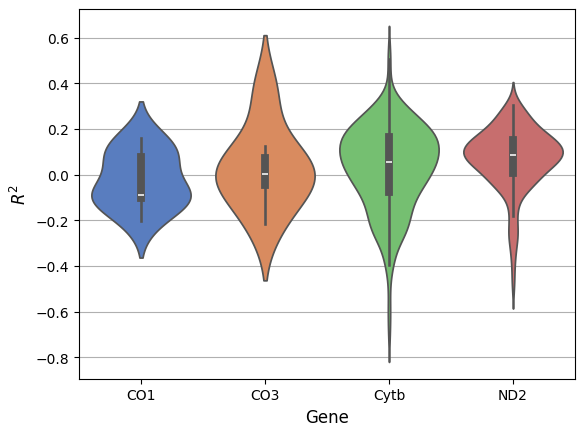

In [48]:
ax=sns.violinplot(data=metrics_df, x='gene', y='r2', palette='muted')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$', fontsize=12)
plt.xlabel('Gene', fontsize=12)

In [51]:
metrics_df.columns

Index(['r2', 'mape', 'wape', 'slope', 'intercept', 'spearman_corr',
       'spearman_p', 'pearson_corr', 'pearson_corr_squared', 'pearson_p',
       'ks_stat', 'ks_p', 'rmse', 'log_likelihood', 'mut_count',
       'mut_type_count', 'corr_chem_vs_rel_freq',
       'corr_chem_vs_rel_freq_pval'],
      dtype='object')

<Axes: >

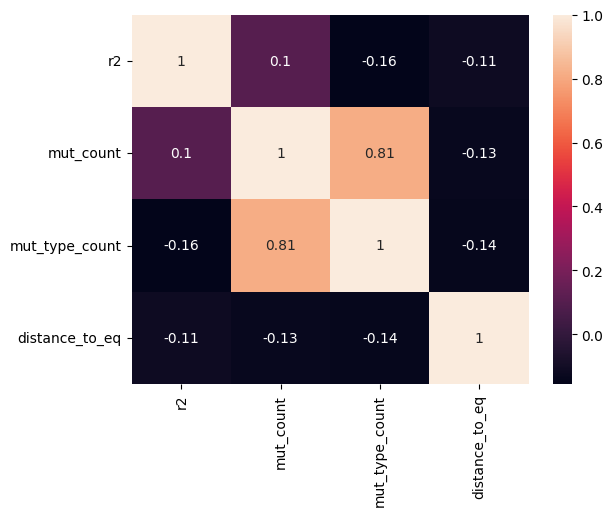

In [81]:
cols = ['r2', 'mut_count', 'mut_type_count', 'distance_to_eq']
sns.heatmap(metrics_df[cols].corr(), annot=True)

<Axes: >

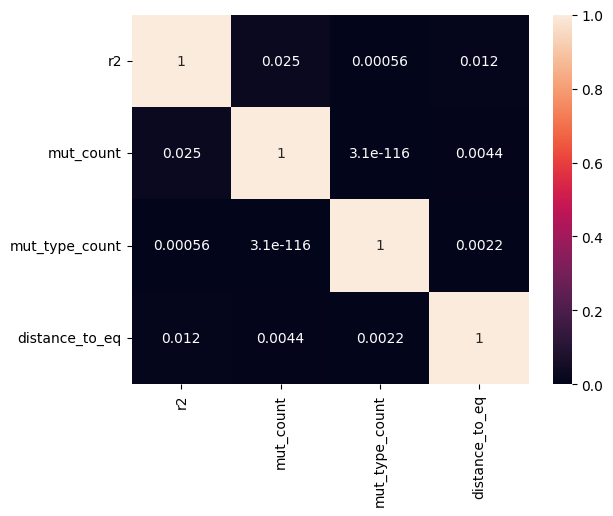

In [82]:
sns.heatmap(metrics_df[cols].corr(method=lambda x, y: pearsonr(x, y)[1]), annot=True)

<Axes: >

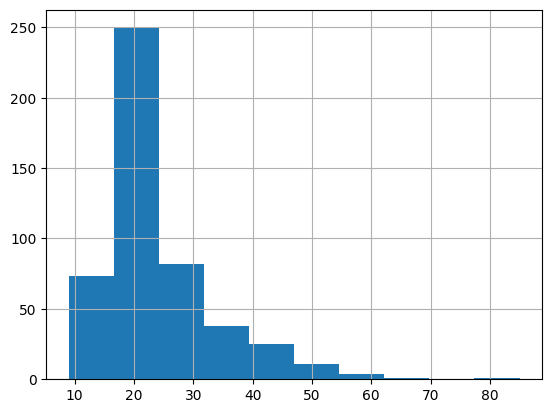

In [83]:
metrics_df.mut_type_count.hist()

<Axes: xlabel='r2', ylabel='mut_count'>

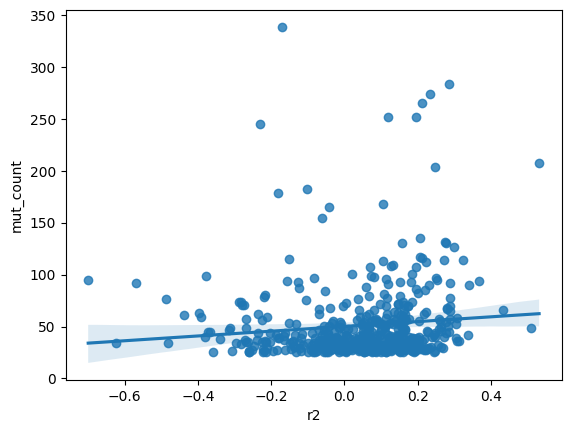

In [84]:
sns.regplot(data=metrics_df, x='r2', y='mut_count')

In [96]:
max_d = metrics_df['distance_to_eq'].quantile(0.99)

<Axes: xlabel='r2', ylabel='distance_to_eq'>

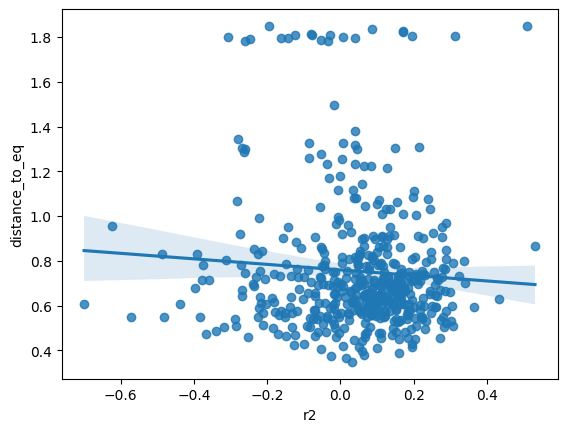

In [97]:
sns.regplot(data=metrics_df.query('distance_to_eq <= @max_d'), x='r2', y='distance_to_eq')